In [1]:
#put the these lines before importing any module from keras.
import tensorflow as tf

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.visible_device_list = "0" #only the gpu 0 is allowed
set_session(tf.Session(config=config))

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-

In [28]:
import os
from os.path import join
import numpy as np
import keras
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from keras.models import Model
from keras.layers import Input, add, LSTM, RepeatVector, TimeDistributed, concatenate
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model
from keras_segmentation.models.model_utils import get_segmentation_model

In [4]:
input_height = 360
input_width = 480
n_classes = 51

img_input = Input(shape=(input_height,input_width , 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

out = Conv2D( n_classes, (1, 1) , padding='same')(conv5)

model = get_segmentation_model(img_input ,  out ) # this would build the segmentation model

In [10]:
plot_model(model, to_file='FCN8.png', show_shapes=True)

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
data_dir = 'dataset1'
os.listdir('dataset1')

['images_prepped_test',
 'annotations_prepped_train',
 'annotations_prepped_test',
 'images_prepped_train']

In [7]:
history = model.train( 
    train_images =  join(data_dir, "images_prepped_train"),
    train_annotations = join(data_dir, "annotations_prepped_train"),
    checkpoints_path = "checkpoints/vgg_unet_1" , epochs=5
)

  6%|▌         | 21/367 [00:00<00:01, 201.55it/s]

Verifying training dataset


100%|██████████| 367/367 [00:01<00:00, 205.78it/s]


Dataset verified! 
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
512/512 [==============================] - 201s 392ms/step - loss: 1.4836 - accuracy: 0.5659
saved  checkpoints/vgg_unet_1.0
Epoch 2/5
512/512 [==============================] - 212s 414ms/step - loss: 0.9540 - accuracy: 0.7034
saved  checkpoints/vgg_unet_1.1
Epoch 3/5
512/512 [==============================] - 200s 391ms/step - loss: 0.8218 - accuracy: 0.7452
saved  checkpoints/vgg_unet_1.2
Epoch 4/5
512/512 [==============================] - 201s 392ms/step - loss: 0.7209 - accuracy: 0.7776
saved  checkpoints/vgg_unet_1.3
Epoch 5/5
512/512 [==============================] - 200s 391ms/step - loss: 0.6566 - accuracy: 0.7980
saved  checkpoints/vgg_unet_1.4


In [29]:
def give_color_to_seg_img(seg, n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [13]:
test_img0 = cv2.imread(join(data_dir, "images_prepped_test", '0016E5_07959.png'))

In [15]:
results = model.predict(test_img0.reshape(1, input_height, input_width, 3))

[[[6.57953471e-02 2.62233824e-01 4.80672047e-02 ... 3.27694090e-03
   4.17999085e-03 3.27047054e-03]
  [4.84910272e-02 3.58967543e-01 2.86500677e-02 ... 2.85597984e-04
   4.19488875e-04 2.15992448e-04]
  [2.64646094e-02 4.34442699e-01 2.62663383e-02 ... 5.88354960e-05
   8.28517877e-05 3.88784683e-05]
  ...
  [1.66630521e-02 3.34656030e-01 2.80914567e-02 ... 3.88932414e-04
   4.42650256e-04 4.26096783e-04]
  [1.47483265e-02 2.88348883e-01 3.53023261e-02 ... 6.80446567e-04
   9.26089298e-04 1.15035311e-03]
  [2.28218101e-02 1.91633403e-01 4.42548133e-02 ... 3.81311728e-03
   4.50194301e-03 6.83335075e-03]]]


In [23]:
results.reshape(input_height, input_width, 51)

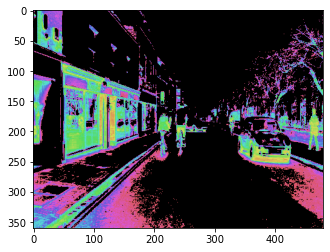

In [31]:
plt.imshow(give_color_to_seg_img(test_img0, n_classes))
plt.show()